<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lasciate ogne speranza, voi ch'intrate**

This is a research scratchpad; it's not designed to be read but rather evolved to test ideas. Please reach out if you'd like a guided tour. 



In [1]:
import itertools
import os

import numpy as np
pi = np.pi

!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html -U

import torch as T
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator
from scipy.linalg import toeplitz
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate
from google.colab import output
!pip install torchdiffeq
!pip install --quiet tensorfont
!pip install --quiet fonttools
!pip install --quiet --upgrade fontParts
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
#!pip install --quiet --upgrade anisotropic-distance-transform
import fontParts
import extractor
import defcon
from torchdiffeq import odeint_adjoint as odeint
#import adt
from ufo2ft import compileOTF

from tensorfont import Font

dev = T.device('cuda' if T.cuda.is_available() else 'cpu')
print("✓ Dependencies imported.")

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.9.0.dev20210215+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.9.0.dev20210215+cu101)
✓ Dependencies imported.


In [2]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


In [3]:
glyph_char_list = "abcdefghijklmnopqrstuvwxyz"
#glyph_char_list = "bdghijlmxnopqu" # straight letters only
#glyph_char_list = "abgjqrstxc"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"
#glyph_char_list = "axcy"

# ==== Create Font ====
factor = 1.0 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = int(f.full_height_px)
box_width = int(161 * factor) # 121
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)
pi = np.float32(np.pi)

batch_size = 8
sample_distance_deltas = [-2, 0, 3]
sample_distance_factors = [.8, 1., 2.0]
n_sample_distances = len(sample_distance_deltas)

n_v1_scales = 10
n_b_scales = 1
n_v1_orientations = 8
n_v4_scales = 8
n_g_scales = n_v1_scales

# ==== Load glyph images ====

def get_glyph_image(glyph_char):
    """Returns a np.array of shape [box_height, box_width] containing the glyph at the center."""
    return f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)

def get_glyph_ink_width(glyph_char):
    """Returns the width of the rendered glyph in pixels."""
    return f.glyph(glyph_char).ink_width

glyph_images = {c: get_glyph_image(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs rendered.", flush=True)
glyph_ink_widths = {c: get_glyph_ink_width(c) for c in tqdm(glyph_char_list)}
print("  ✓", len(glyph_char_list), "glyphs measured.", flush=True)

100%|██████████| 26/26 [00:00<00:00, 1194.67it/s]

Box size: 80 × 161
  ✓ 26 glyphs rendered.



100%|██████████| 26/26 [00:00<00:00, 14398.19it/s]

  ✓ 26 glyphs measured.


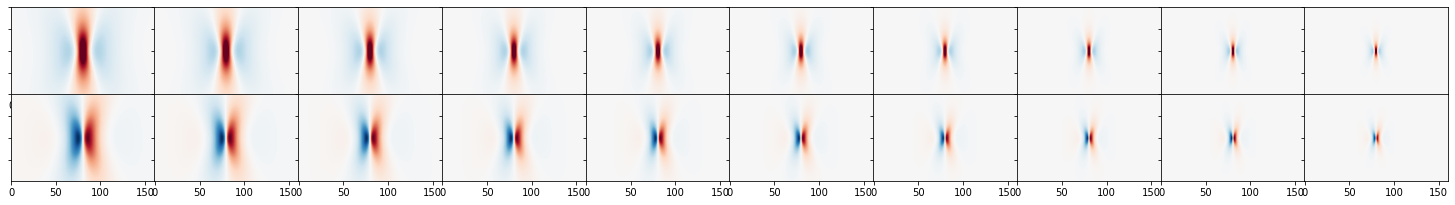

In [4]:
def get_sigmas(skip_scales=0):
    sigmas = []
    min_sigma = 1.9 # the bigger this is, the smaller the extent of the largest filter
    factor = 1.18  # the bigger this is, the more decay (so the smallest filter becomes even smaller)
    for s in range(n_v1_scales):
        sigmas.append(min_sigma * factor ** s)
    return T.tensor(sigmas)

def get_v1_filter_bank(skip_scales, display_filters=False, display_fft=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = T.tensor([[ np.cos(pi*oi/n_v1_orientations), np.sin(pi*oi/n_v1_orientations)],
                                [-np.sin(pi*oi/n_v1_orientations), np.cos(pi*oi/n_v1_orientations)]], dtype=T.float32)
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = T.meshgrid(T.arange(-hh, hh), T.arange(-bw, bw))
        y = y + 0.05 # 0 if box_height % 2 == 0 else 0.5
        x = x + 0.05 # 0 if box_width % 2 == 0 else 0.5
        return T.einsum('ji, mni -> jmn', rotation, T.dstack([x, y]))

    bx, by = rotated_mgrid(0)
    unit_freqs = T.sqrt((bx / box_width)**2+(by/box_height)**2)
    unit_freqs[box_height, box_width] = 1.
    lowpassfilter = 1.0 / (1.0 + (unit_freqs / 0.9)**20)

    bandwidth = 0.75
    def get_filter_log_gabor(s, theta):
        x, y = rotated_mgrid(0)

        x = x * box_height / box_width
        # In this case, we will create the filter directly in the frequency domain.
        freqs = T.sqrt(x**2+y**2)
        freqs[box_height, box_width] = 1.
        target_freq = s
        freq_ring = T.exp(-(T.log(unit_freqs * box_height / target_freq))**2) / (2 * np.log(bandwidth)**2)
        freq_ring[box_height, box_width] = 0

        # Remove the corners of the FFT by passing through a large circle with round edges
        freq_ring *= lowpassfilter

        # Now for the angular filter, we can use a von Mises function. We only want this to go around one side, only on the positive real.
        angle = T.atan2(y, x)
        angle = T.where(angle<0 , 2*pi+angle, angle)
        k = 8
        angular_filter = T.exp(k * T.cos(angle - theta*pi/n_v1_orientations)) / (2*pi*np.i0(k))

        real_filter = freq_ring * angular_filter

        # We want the same energy in every filter. How do we achieve this? We want to take the area that it covers in the FFT and make the max equal to one.
        return T.fft.ifftshift(-real_filter + 0j)

    filter_bank = T.zeros((n_v1_scales, n_v1_orientations, 2*box_height, 2*box_width), dtype=T.complex64)

    if display_filters:
        sizediv = 50
        #fig, ax = plt.subplots(nrows=n_v1_scales*2, ncols=n_v1_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, box_height * n_v1_scales * 2 / sizediv))
        fig, ax = plt.subplots(2, n_v1_scales, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_v1_orientations / sizediv, 2*box_height / sizediv))

    sigmas = get_sigmas()
    totalfilter = 0
    for s in range(n_v1_scales):
        sigma = sigmas[s]
        for o in range(n_v1_orientations):
            f = get_filter_log_gabor(sigma, o)
            if display_filters and o == 0:
                mx = T.max(T.abs(T.imag(T.fft.ifft2(f))))
                ax[0,s].imshow(T.real(T.fft.fftshift(T.fft.ifft2(f)))[int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], cmap="RdBu", vmin=-mx, vmax=mx)
                ax[0,s].set_aspect("auto")
                ax[0,s].set_yticklabels([])
                ax[1,s].imshow(T.imag(T.fft.fftshift(T.fft.ifft2(f)))[int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                      int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], cmap="RdBu", vmin=-mx, vmax=mx)
                ax[1,s].set_aspect("auto")
                ax[1,s].set_yticklabels([])
            if display_fft:
                totalfilter += T.fft.fftshift(f)
            filter_bank[s, o, :, :] = f

    if display_filters:
        plt.show()
    if display_fft:
        plt.imshow(T.real(totalfilter))
        plt.colorbar()
        plt.show()
        plt.imshow(T.imag(totalfilter))
        plt.colorbar()
        plt.show()

    return filter_bank

filter_bank = get_v1_filter_bank(0, display_filters=True, display_fft=False)


def apply_filter_bank(input_image, filter_bank, invert=False):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    fbs = filter_bank.shape[-2:]
    if invert:
        bsohwd_input_image = input_image[None, None, :, :, :, :]
        input_in_freqdomain = T.fft.fft2(bsohwd_input_image, s=fbs)
        padded_result = T.fft.ifft2(T.sum(input_in_freqdomain, dim=[2, 3]))
        return padded_result[0, 0, :box_height, :box_width]
    else:
        bdsohw_input_image = input_image[None, None, None, None, :, :]
        input_in_freqdomain = T.fft.fft2(T.tensor(np.array(bdsohw_input_image) + 0j, dtype=T.complex64), s=fbs)
        padded_result = T.fft.ifft2(input_in_freqdomain * filter_bank[None, None, :, :, :, :])
        return padded_result[0, 0, :, :, :box_height, :box_width]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


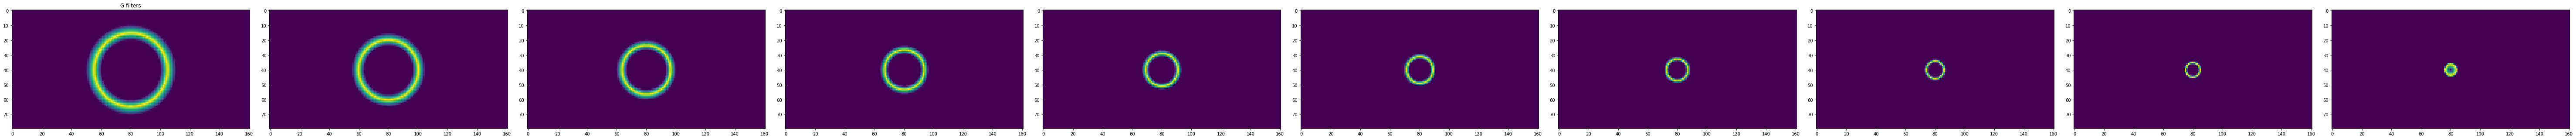

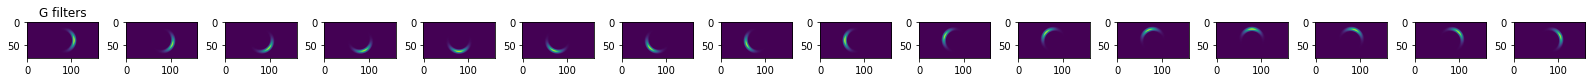

In [5]:
class G_filters(T.nn.Module):
    """
    Creates the annular G-cell filters, one set for each phase.
    Returns: <s, o, p, h, w>
    """
    def __init__(self):
        super().__init__()

        self.factor = T.tensor(0.4/33.).to(dev)

        # adjust until factor*base**(n_g_scales+1) = box_height / box_width
        # so n_g_scales + 1 = log(box_height / (box_width * factor)) / n_g_scales + 1 = log(base)

        self.base = T.tensor(np.exp(np.log(0.7*box_height / (2*box_width * self.factor.cpu())) / (n_g_scales + 3))).to(dev)


        self.u, self.v = T.meshgrid(T.arange(-box_height, box_height, dtype=T.float32),
                          T.arange(-box_width, box_width, dtype=T.float32))
        self.u = self.u / (2*box_width)
        self.v = self.v / (2*box_width)
        self.r = T.sqrt(self.u**2 + self.v**2).to(dev)
        self.bp_angle_masks, self.bn_angle_masks = self.make_angle_masks()

    def make_angle_masks(self):
        angle = T.atan2(self.u, self.v)[None, None, :, :] # <o, c, h, w>
        angles = T.arange(n_v1_orientations, dtype=T.float32)[:, None, None, None]/n_v1_orientations
        
        # Uses von-Mises distribution (via Bessel function)
        angle_mask_widths = T.tensor([4.])
        bp_angle_masks = T.exp(-angle_mask_widths * T.cos(angle - pi - pi * angles)) / (2*pi*np.i0(angle_mask_widths))
        bn_angle_masks = T.exp(-angle_mask_widths * T.cos(angle - pi * angles)) / (2*pi*np.i0(angle_mask_widths))

        return bp_angle_masks, bn_angle_masks

    def make_radial_masks(self):
        rs = T.cat([T.tensor([0]).to(dev), self.factor * self.base ** T.arange(n_g_scales + 1).to(dev)]) # makes it <c=8, p=4>

        radial_masks = T.zeros((1, n_g_scales, 2*box_height, 2*box_width))

        for i in range(n_g_scales):
            a, c, b = rs[i], rs[i + 1], rs[i + 2]
            updiagonal = 2*(self.r - a) / ((b-a)*(c-a))
            downdiagonal = 2*(b-self.r) / ((b-a)*(b-c))
            radial_masks[:, i, :, :] = F.relu(T.minimum(updiagonal, downdiagonal))[None, :, :]  # make it <o, c, p, h, w>
    
        return T.flip(radial_masks, dims=[1])  # We actually want to start with the biggest radius, because the first V1 filter is the largest, too

    def forward(self): # Returns masks of shape <o, c, h, w>
        #print("G params", [p.T.detach().cpu().numpy() for p in self.parameters()])

        radial_masks = self.make_radial_masks()

        bp_masks = radial_masks * self.bp_angle_masks
        bn_masks = radial_masks * self.bn_angle_masks
    
        # Each bp/bn_mask fragment should add up to exactly one.
        eps = 1e-10
        bp_masks_normed = 4*bp_masks / (eps + T.sum(F.relu(bp_masks), (0, -2, -1), keepdims=True))
        bn_masks_normed = 4*bn_masks / (eps + T.sum(F.relu(bn_masks), (0, -2, -1), keepdims=True))
    
        return T.einsum("ochw->cohw", T.clip(T.cat([bp_masks_normed, bn_masks_normed], axis=0), -1e12, 1e12))

def test_G_filters():
    gf = G_filters().to(dev)()  # create and run, in one go

    fig, ax = plt.subplots(1, n_g_scales, figsize=[82, 35], constrained_layout=True)
    ax[0].set_title("G filters")
    for i in range(n_g_scales):
        ax[i].imshow(np.sum(gf.detach().cpu().numpy()[i, :,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))], (0)))
    plt.show()

    fig, ax = plt.subplots(1, 2*n_v1_orientations, figsize=[22, 9], constrained_layout=True)
    ax[0].set_title("G filters")
    for i in range(2*n_v1_orientations):
        ax[i].imshow(gf.detach().cpu().numpy()[0, i,   
                                        int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                        int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))])
    plt.show()

test_G_filters()

In [6]:
class B_G_Differential(T.nn.Module):
    def __init__(self):
        super().__init__()

        #self.G_input_weight = T.nn.Parameter(T.tensor([1.0] * n_v1_scales, requires_grad=False)[:, None, None, None])
        #self.G_output_weight = T.nn.Parameter(T.tensor([5.0] * n_v1_scales, requires_grad=False)[:, None, None, None, None])
        #self.G_decay_rate = T.nn.Parameter(T.tensor([1.0] * n_v1_scales, requires_grad=False)[:, None, None, None])
        #self.B_inhibition_weight = T.nn.Parameter(T.tensor([1.0] * n_v1_scales, requires_grad=False)[:, None, None, None, None])
        #self.B_decay_rate = T.nn.Parameter(T.tensor([20.0] * n_v1_scales, requires_grad=False)[:, None, None, None, None])

        self.G_input_weight = T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None]
        self.G_output_weight = T.tensor([5.0] * n_v1_scales).to(dev)[:, None, None, None, None]
        self.G_decay_rate = T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None]
        self.B_inhibition_weight = T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None, None]
        self.B_decay_rate = T.tensor([2.0] * n_v1_scales).to(dev)[:, None, None, None, None]

    def conv_b_to_g(self, b, g_filters_fft):
        """Projection upwards from B to G cells. <bd sohw> → <bd shw>"""

        b_fft = T.fft.fft2(b + 0j, s=g_filters_fft.shape[-2:])
        result = T.real(T.fft.ifft2(b_fft * g_filters_fft))[..., :b.shape[-2], :b.shape[-1]]
        return T.sum(result, dim=[-3]) # sum over all incoming orientations

    def get_g_inputs(self, b, g_filters_fft):
        """Collect inputs from B cells for all four phases. <bd sophw> → <bd sphw>"""

        gi0 = self.conv_b_to_g(b[..., 0, :, :], g_filters_fft) # wbw
        gi1 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 1, :, :], b[..., n_v1_orientations:, 3, :, :]], dim=-3), g_filters_fft)  # bw
        gi2 = self.conv_b_to_g(b[..., 2, :, :], g_filters_fft) # bwb
        gi3 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 3, :, :], b[..., n_v1_orientations:, 1, :, :]], dim=-3), g_filters_fft)  # wb

        if False:
            plt.imshow(self.conv_b_to_g(T.cat([b[:, :n_v1_orientations, 1, :, :], T.zeros_like(b[:, :n_v1_orientations, 0, :, :])], dim=-3), g_filters_fft)[2, :, :].detach().cpu().numpy())
            plt.title("g from scale 2 phase 0 down")
            plt.colorbar()
            plt.show()

        return T.stack([gi0, gi1, gi2, gi3], dim=-3) # stack phases together

    def conv_g_to_b(self, g, g_filters_inverse_fft):
        """Projection downwards from G to B cells. <bd sphw> → <bd sohw>"""

        g_fft = T.fft.fft2(g, s=g_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * g_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...
        return result  # <bd sophw>, where o is doubled up and will need to be split up

    def get_b_amplification(self, g, g_filters_inverse_fft):
        """Collect inputs from G to B cells for all four phases. <bd sphw> → <bd sophw>"""
        
        projections = self.conv_g_to_b(g, g_filters_inverse_fft)

        # Now we need to split these projections <bd sophw> back into the phases they came from, to get the gain factors for <bd sophw> 
        # This works naturally for phases 0 and 2, but for 1 and 3 it will be wrong.
        p0 = projections[..., 0, :, :]
        p1 = T.cat([projections[..., :n_v1_orientations, 1, :, :], projections[..., n_v1_orientations:, 3, :, :]], dim=-3) # is 
        p2 = projections[..., 2, :, :]
        p3 = T.cat([projections[..., :n_v1_orientations, 3, :, :], projections[..., n_v1_orientations:, 1, :, :]], dim=-3)

        return T.stack([p0, p1, p2, p3], dim=-3) 

    def get_b_inhibition(self, b):
        """Find the opposites of the respective B cells."""

        return T.roll(b, [n_v1_orientations], [-3]) / 10000

        #i0 = T.cat([b[..., n_v1_orientations:, 0, :, :], b[..., :n_v1_orientations, 0, :, :]], dim=-3)  # <bd sophw>  # the opposite is the same phase, but the other side.
        #i1 = T.cat([b[..., n_v1_orientations:, 1, :, :], b[..., :n_v1_orientations, 1, :, :]], dim=-3)
        #i2 = T.cat([b[..., n_v1_orientations:, 2, :, :], b[..., :n_v1_orientations, 2, :, :]], dim=-3)
        #i3 = T.cat([b[..., n_v1_orientations:, 3, :, :], b[..., :n_v1_orientations, 3, :, :]], dim=-3)
        #return T.stack([i0, i1, i2, i3], dim=-3)  # <bd sophw>

    def forward(self, t, state):
        # b: <bd sophw>  p = phase (4), and o=2*n_v1_orientations
        # g: <bd sphw>  p = phase (4)

        # g_filters, g_filters_fft, g_filters_inverse_fft, input_b_response

        (b, g,
         g_filters_fft_real,
         g_filters_fft_imag,
         g_filters_inverse_fft_real,
         g_filters_inverse_fft_imag,
         input_b_response) = state  

        g_filters_fft = g_filters_fft_real + g_filters_fft_imag * 1j
        g_filters_inverse_fft = g_filters_inverse_fft_real + g_filters_inverse_fft_imag * 1j

        # So, what are the relationships between the respective neurons here?
        # First, we want to compute the respective G cell excitation caused by the G cells

        # compute g_inputs
        # First, the even part (rp=Mexican hat, rn=inverse Mexican hat).
        # Each G cell takes either from 
        g_inputs = self.get_g_inputs(b, g_filters_fft)  # <bd sphw>
        d_g = -g*self.G_decay_rate + F.relu(g_inputs * self.G_input_weight)
        # Then, we project down the G strength onto the B cells, and we amplify them

        b_amplification = self.get_b_amplification(g, g_filters_inverse_fft)

        if True:
            print("b_amplification at time", t, "max is", T.max(b_amplification).detach().cpu().numpy())
            fig, ax = plt.subplots(1, 4, figsize=(10,3))
            ax[0].imshow(T.sum(b_amplification[2, :n_v1_orientations, 0, :, :], dim=[0]).detach().cpu().numpy())
            ax[1].imshow(T.sum(b_amplification[2, n_v1_orientations:, 0, :, :], dim=[0]).detach().cpu().numpy())
            ax[2].imshow(T.sum(b_amplification[2, :n_v1_orientations, 1, :, :], dim=[0]).detach().cpu().numpy())
            ax[3].imshow(T.sum(b_amplification[2, n_v1_orientations:, 1, :, :], dim=[0]).detach().cpu().numpy())
            plt.show()

        # compute b_inhibition
        b_inhibition = self.get_b_inhibition(b)

        if True:
            print("b_inhibition at time", t, "max is", T.max(b_inhibition).detach().cpu().numpy())
            fig, ax = plt.subplots(1, 4, figsize=(10,3))
            ax[0].imshow(T.sum(b_inhibition[2, :n_v1_orientations, 0, :, :], dim=[0]).detach().cpu().numpy())
            ax[1].imshow(T.sum(b_inhibition[2, n_v1_orientations:, 0, :, :], dim=[0]).detach().cpu().numpy())
            ax[2].imshow(T.sum(b_inhibition[2, :n_v1_orientations, 1, :, :], dim=[0]).detach().cpu().numpy())
            ax[3].imshow(T.sum(b_inhibition[2, n_v1_orientations:, 1, :, :], dim=[0]).detach().cpu().numpy())
            plt.show()


        #max input b response 2.25538
        #max input b amplification 0.0
        #max input b amplification 0.020914966
        #max G output weight 5.0
        #max positive part 2.25538
        #max inhibition 2.25538
        #max inhibition weight 100.0

        # compute b_amplification
        d_b = (
            -b * self.B_decay_rate
            + F.relu( 
                input_b_response*(b_amplification*self.G_output_weight + 1.)
                -b_inhibition*self.B_inhibition_weight 
            )
        )

        #print("------")
        #print("max input b response", T.max(input_b_response).detach().cpu().numpy())
        #print("max input b amplification", T.max(b_amplification).detach().cpu().numpy())
        #print("max G output weight", T.max(self.G_output_weight).detach().cpu().numpy())
        #print("max positive part", T.max(input_b_response*(b_amplification*self.G_output_weight + 1.)).detach().cpu().numpy())
        #print("max inhibition", T.max(b_inhibition).detach().cpu().numpy())
        #print("max inhibition weight", T.max(self.B_inhibition_weight).detach().cpu().numpy())
        #print("max self value:", T.max(b).detach().cpu().numpy())
        #print("max total change:", T.max(d_b).detach().cpu().numpy())
        #print("min total change:", T.min(d_b).detach().cpu().numpy())

        #print("Differntial params", [p.T.detach().cpu().numpy() for p in self.parameters()])

        return (d_b, d_g, T.zeros_like(g_filters_fft_real).to(dev),
                T.zeros_like(g_filters_fft_imag).to(dev),
                T.zeros_like(g_filters_inverse_fft_imag).to(dev),
                T.zeros_like(g_filters_inverse_fft_imag).to(dev),
                T.zeros_like(input_b_response).to(dev))

In [14]:
class B_G_Direct(T.nn.Module):
    def __init__(self):
        super().__init__()

        self.gain_d = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>

        self.b_to_g = T.nn.Parameter(T.eye(n_v1_scales).to(dev))

        self.G_input_weight = T.nn.Parameter(T.tensor([1.0] * n_v1_scales).to(dev)[:, None, None, None])
        self.amplification_saturation = T.nn.Parameter(0.7 * T.ones((n_v1_scales, 2*n_v1_orientations)).to(dev)[:, :, None, None, None])
        self.k = T.nn.Parameter(T.tensor([.25] * n_v1_scales).to(dev)[:, None, None, None, None])
        self.b = T.nn.Parameter(T.tensor([.55] * n_v1_scales).to(dev)[:, None, None, None, None])

    def conv_b_to_g(self, b, g_filters_fft):
        """Projection upwards from B to G cells. <bd sohw> → <bd shw>"""

        b_fft = T.fft.fft2(b + 0j, s=g_filters_fft.shape[-2:])
        result = T.real(T.fft.ifft2(b_fft * g_filters_fft))[..., :b.shape[-2], :b.shape[-1]]
        return T.sum(result, dim=[-3]) # sum over all incoming orientations

    def get_g_inputs(self, b, g_filters_fft):
        """Collect inputs from B cells for all four phases. <bd sophw> → <bd sphw>"""

        gi0 = self.conv_b_to_g(b[..., 0, :, :], g_filters_fft) # wbw
        gi1 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 1, :, :], b[..., n_v1_orientations:, 3, :, :]], dim=-3), g_filters_fft)  # bw
        gi2 = self.conv_b_to_g(b[..., 2, :, :], g_filters_fft) # bwb
        gi3 = self.conv_b_to_g(T.cat([b[..., :n_v1_orientations, 3, :, :], b[..., n_v1_orientations:, 1, :, :]], dim=-3), g_filters_fft)  # wb

        if False:
            plt.imshow(self.conv_b_to_g(T.cat([b[:, :n_v1_orientations, 1, :, :], T.zeros_like(b[:, :n_v1_orientations, 0, :, :])], dim=-3), g_filters_fft)[2, :, :].detach().cpu().numpy())
            plt.title("g from scale 2 phase 0 down")
            plt.colorbar()
            plt.show()

        return T.stack([gi0, gi1, gi2, gi3], dim=-3) # stack phases together

    def conv_g_to_b(self, g, g_filters_inverse_fft):
        """Projection downwards from G to B cells. <bd sphw> → <bd sohw>"""

        g_fft = T.fft.fft2(g, s=g_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * g_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...
        return result  # <bd sophw>, where o is doubled up and will need to be split up

    def get_b_amplification(self, g, g_filters_inverse_fft):
        """Collect inputs from G to B cells for all four phases. <bd sphw> → <bd sophw>"""
        
        projections = self.conv_g_to_b(g, g_filters_inverse_fft)

        # Now we need to split these projections <bd sophw> back into the phases they came from, to get the gain factors for <bd sophw> 
        # This works naturally for phases 0 and 2, but for 1 and 3 it will be wrong.
        p0 = projections[..., 0, :, :]
        p1 = T.cat([projections[..., :n_v1_orientations, 1, :, :], projections[..., n_v1_orientations:, 3, :, :]], dim=-3) # is 
        p2 = projections[..., 2, :, :]
        p3 = T.cat([projections[..., :n_v1_orientations, 3, :, :], projections[..., n_v1_orientations:, 1, :, :]], dim=-3)

        return T.stack([p0, p1, p2, p3], dim=-3) 

    def normalize_b(self, b):
        """Find the opposites of the respective B cells."""

        # Normalization pool: let's say it's equal for now; in the future we can build a parameter matrix.
        # Normalization pool: for each phase, double up the top and bottom orientations

        kappa = self.k * 10
        kappa += (T.randn_like(kappa) * F.relu(kappa) / 46).detach()
        kappa = F.softplus(kappa, 100)
        beta = self.b * 10
        beta += (T.randn_like(beta) * F.relu(beta) / 46).detach()
        beta = F.softplus(beta, 100)

        pool = b[..., n_v1_orientations:, :, :, :] ** kappa + b[..., :n_v1_orientations, :, :, :] ** kappa
        pool = beta + T.cat([pool] * 2, dim=-4)
        return b ** kappa / pool


    def forward(self, x, plot):
        # b: <bd sophw>  p = phase (4), and o=2*n_v1_orientations
        # g: <bd sphw>  p = phase (4)

        (b, g, # g is ignored here
         g_filters_fft_real,
         g_filters_fft_imag,
         g_filters_inverse_fft_real,
         g_filters_inverse_fft_imag,
         input_b_response) = x

        g_filters_fft = g_filters_fft_real + g_filters_fft_imag * 1j
        g_filters_inverse_fft = g_filters_inverse_fft_real + g_filters_inverse_fft_imag * 1j

        # First, we will create a cross between different B cells such that each G cell is interacting with the right range of B cells.
        # Hopefully there won't be too much wrongful interaction.
        # We can ensure this by making sure each B cell scale is captured by only one G cell in total.
        b = T.einsum("bdsophw,sg->bdgophw", b, F.softplus(self.b_to_g, 100) / T.sum(F.softplus(self.b_to_g, 100), dim=[1], keepdim=True))

        # Apply some noise to the B cells, to help prevent overfitting.
        # We first blur every layer in b by one across b and g
        b += (T.randn_like(b) * F.relu(b) / 36).detach()

        # So, what are the relationships between the respective neurons here?
        # First, we want to compute the respective G cell excitation caused by the G cells

        # First, the even part (rp=Mexican hat, rn=inverse Mexican hat).
        # Each G cell takes either from
        giw = self.G_input_weight * 10
        giw += (T.randn_like(giw) * F.relu(giw) / 36).detach()

        g = giw * self.get_g_inputs(b, g_filters_fft)  # <bd sphw>

        b_amplification = self.get_b_amplification(g, g_filters_inverse_fft)

        sas = F.softplus(self.amplification_saturation + (T.randn_like(self.amplification_saturation.detach()) * F.relu(self.amplification_saturation.detach()) / 48).detach(), 100)

        # Now, apply the b_amplification
        b_amplified = b * (1 + b_amplification) ** sas

        # Now, perform divisive normalization between opponent B cells
        b_normalized = self.normalize_b(b_amplified)

        # Now recompute the G cells from the B cells
        g = giw * self.get_g_inputs(b_normalized, g_filters_fft)

        if plot:
            print("BG Direct parameters:")

            plt.plot(self.G_input_weight[:, 0, 0 ,0].detach().cpu().numpy())
            plt.title("G input weights")
            plt.show()
            plt.imshow(F.softplus(self.amplification_saturation, 100)[:, :, 0, 0 ,0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("amplification saturation exponent")
            plt.show()
            plt.plot(F.softplus(self.b, 100)[:, 0, 0, 0 ,0].detach().cpu().numpy())
            plt.title("beta")
            plt.show()
            plt.plot(F.softplus(self.k, 100)[:, 0, 0, 0 ,0].detach().cpu().numpy())
            plt.title("kappa")
            plt.show()
            plt.imshow(F.softplus(self.b_to_g, 100).detach().cpu().numpy())
            plt.colorbar()
            plt.show()


        return (b_normalized, g, T.zeros_like(g_filters_fft_real).to(dev),
                T.zeros_like(g_filters_fft_imag).to(dev),
                T.zeros_like(g_filters_inverse_fft_imag).to(dev),
                T.zeros_like(g_filters_inverse_fft_imag).to(dev),
                T.zeros_like(input_b_response).to(dev))

In [8]:
class B_Reward_Coefficients(T.nn.Module):
    def __init__(self):
        super().__init__()

        atemplate = T.ones((n_v1_scales, 4, 1, 1))
        #atemplate[3:, ...] = 0.
        #atemplate[:2, ...] = 0.

        self.gain_a = T.nn.Parameter(atemplate)  # <sphw>
        self.gain_b = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_c = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.gain_d = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_a = T.nn.Parameter(atemplate)  # <sphw>
        self.loss_b = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_c = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)))  # <sphw>
        self.loss_d = T.nn.Parameter(T.zeros((n_v1_scales, 4, 1, 1)))  # <sphw>

    def conv_g_to_b(self, g, g_filters_inverse_fft):
        # apply the ring convolution to the pairing of this <bd sphw> to make two <bd sohw>
        # by applying the ring segments in reverse
        g_fft = T.fft.fft2(g, s=g_filters_inverse_fft.shape[-2:])[..., None, :, :, :]  # insert empty o dimension for <bd sophw>
        result = T.real(T.fft.ifft2(g_fft * g_filters_inverse_fft[..., None, :, :]))[..., :g.shape[-2], :g.shape[-1]]  # does this broadcast correctly, aligned at the end? hopefully ...

        return result  # <bd sophw>, where o is double, ... but we need to split them up

    def get_b_gradient(self, g, g_filters_inverse_fft):
        # we have <bd sphw> and we want to get <bd sopchw>. So this is exactly the opposite as the above.
        # we get back <bd sophw>, and we would like 
        projections = self.conv_g_to_b(g, g_filters_inverse_fft)

        p0 = projections[..., :n_v1_orientations, 0, :, :] + projections[..., n_v1_orientations:, 0, :, :]
        p1 = projections[..., :n_v1_orientations, 1, :, :] + projections[..., n_v1_orientations:, 3, :, :]
        p2 = projections[..., :n_v1_orientations, 2, :, :] + projections[..., n_v1_orientations:, 2, :, :]
        p3 = projections[..., :n_v1_orientations, 3, :, :] + projections[..., n_v1_orientations:, 1, :, :]

        return T.stack([p0, p1, p2, p3], dim=-3)  # <bd sophw>

    def forward(self, inputs):
        (g, g_filters_inverse_fft, plot) = inputs

        g_gain_penalties = (1e-5 + F.relu(g * self.gain_a)) ** F.softplus(self.gain_b) * T.exp(-g**2 / (1e-5 + self.gain_c**2)) + F.softplus(self.gain_d, 1000)
        g_loss_penalties = (1e-5 + F.relu(g * self.loss_a)) ** F.softplus(self.loss_b) * T.exp(-g**2 / (1e-5 + self.loss_c**2)) + F.softplus(self.loss_d, 1000)

        if plot:

            gainpeak = (T.sqrt(T.mean(self.gain_b)) * T.mean(self.gain_c) / np.sqrt(2.)).detach().cpu().numpy()
            print("mean gain peak at", gainpeak)
            losspeak = (T.sqrt(T.mean(self.loss_b)) * T.mean(self.loss_c) / np.sqrt(2.)).detach().cpu().numpy()
            print("mean loss peak at", losspeak)

            fig, ax = plt.subplots(2, 4)
            ax[0, 0].imshow(self.gain_a.detach().cpu().numpy()[:, :, 0, 0])
            ax[0, 1].imshow(F.softplus(self.gain_b[:, :, 0, 0]).detach().cpu().numpy())
            ax[0, 2].imshow(self.gain_c.detach().cpu().numpy()[:, :, 0, 0])
            ax[0, 3].imshow(F.softplus(self.gain_d, 1000).detach().cpu().numpy()[:, :, 0, 0])
            ax[1, 0].imshow(self.loss_a.detach().cpu().numpy()[:, :, 0, 0])
            ax[1, 1].imshow(F.softplus(self.loss_b[:, :, 0, 0]).detach().cpu().numpy())
            ax[1, 2].imshow(self.loss_c.detach().cpu().numpy()[:, :, 0, 0])
            ax[1, 3].imshow(F.softplus(self.loss_d, 1000).detach().cpu().numpy()[:, :, 0, 0])
            plt.show()

        b_gain_grads = self.get_b_gradient(g_gain_penalties, g_filters_inverse_fft)  # <bd sophw>, with 8 orientations
        b_loss_grads = self.get_b_gradient(g_loss_penalties, g_filters_inverse_fft)  # <bd sophw>, with 8 orientations

        return (b_gain_grads, b_loss_grads)

In [15]:
g_filters = G_filters().to(dev)()
g_filters_fft = T.fft.fft2(T.fft.ifftshift(g_filters + 0j, [-2, -1])).to(dev)
g_filters_inverse_fft = T.roll(g_filters_fft, [n_v1_orientations], dims=[-3]).to(dev)

class YinYangFit(T.nn.Module):
    def __init__(self, g_filters_inverse_fft):
        super().__init__()

        self.g_filters_inverse_fft = g_filters_inverse_fft
        self.b_reward_coefficients = B_Reward_Coefficients().to(dev)

        self.gains_exps = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)) * 0.7)  # <sphw>
        self.losses_exps = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)) * 0.7) # <sphw>
        self.gains_rewards = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)) * 0.01)  # <sphw>
        self.losses_penalties = T.nn.Parameter(T.ones((n_v1_scales, 4, 1, 1)) * 0.01) # <sphw>

        self.bg_direct = B_G_Direct()

    def compute_v1_changes(self, p1, p2):
        """Returns the changes to each phase. <bd sohw> → <bd sophw>"""
        def c(m, p):
            gains = F.relu(T.stack([F.relu(T.real(m)) - F.relu(T.real(p)),
                            F.relu(T.imag(m)) - F.relu(T.imag(p)),
                            F.relu(-T.real(m)) - F.relu(-T.real(p)),
                            F.relu(-T.imag(m)) - F.relu(-T.imag(p))], axis=-3))
            
            losses = F.relu(-T.stack([F.relu(T.real(m)) - F.relu(T.real(p)),
                                F.relu(T.imag(m)) - F.relu(T.imag(p)),
                                F.relu(-T.real(m)) - F.relu(-T.real(p)),
                                F.relu(-T.imag(m)) - F.relu(-T.imag(p))], axis=-3))
            
            return gains ** F.softplus(self.gains_exps), losses ** F.softplus(self.losses_exps)

        m = p1 + p2
        return c(m, p1), c(m, p2)


    def apply_g_filters(self, image, g_filters_fft, g_filters_inverse_fft, plot):
        b_doubled = T.cat([image] * 2, dim=-3).to(dev)  # double up the B cells along the orientation axis
        b_initial = T.stack([F.relu(T.real(b_doubled)),
                             F.relu(T.imag(b_doubled)),
                             F.relu(-T.real(b_doubled)),
                             F.relu(-T.imag(b_doubled))], axis=-3).to(dev)

        g_initial = T.zeros_like(b_initial[..., 0, :, :, :]).to(dev) # <bd sophw> -> <bd sphw>, delete

        # This is really annoying, but we need to split up the filters into real and imaginary,
        # because of a limitation of odeint.
        initial_state = (b_initial, 
                         g_initial,
                         T.real(g_filters_fft),
                         T.imag(g_filters_fft),
                         T.real(g_filters_inverse_fft),
                         T.imag(g_filters_inverse_fft),
                         b_initial)

        # Integrate over a few time steps

        b_out, g_out, _, _, _, _, _ = self.bg_direct(initial_state, plot)
        return (b_out, g_out)


    def forward(self, inputs):
        p1, p2, g1, g2, plot = inputs

        # Get the G filters for the first letter, the second letter, and the 
        _, gr1 = self.apply_g_filters(p1, g_filters_fft, g_filters_inverse_fft, plot)
        _, gr2 = self.apply_g_filters(p2, g_filters_fft, g_filters_inverse_fft, plot)
        _, grp = self.apply_g_filters(p1 + p2, g_filters_fft, g_filters_inverse_fft, plot)

        # Now compute the difference between the G cells 
        delta_g = grp - (gr1 + gr2)

        gains = F.relu(delta_g) ** F.softplus(self.gains_exps) + (T.randn_like(delta_g) * F.relu(delta_g.detach()) / 32).detach()
        losses = F.relu(-delta_g) ** F.softplus(self.losses_exps) + (T.randn_like(delta_g) * F.relu((-delta_g).detach()) / 32).detach()

        rewards = gains * self.gains_rewards - losses * self.losses_penalties
        # Now plot the difference in G cells

        if plot:
            maxg = T.max(delta_g[0, 1, ...]).detach().cpu().numpy()
            fig, ax = plt.subplots(n_v1_scales, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, n_v1_scales*box_height / 30))
            (t1, t2) = get_pair_translations(g1[0], g2[0], sample_distance_deltas)
            gi1, gi2 = T.tensor(glyph_images[g1[0]]).to(dev), T.tensor(glyph_images[g2[0]]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            for i in range(n_v1_scales):
                ax[i, 0].imshow(delta_g[0, 1, i, 0, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 1].imshow(delta_g[0, 1, i, 1, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 2].imshow(delta_g[0, 1, i, 2, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 3].imshow(delta_g[0, 1, i, 3, :, :].detach().cpu().numpy(), vmin=-maxg, cmap="RdBu", vmax=maxg)
                ax[i, 0].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 1].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 2].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
                ax[i, 3].imshow((git1 + git2)[1, ...].detach().cpu().numpy(), alpha=0.1, cmap="gray")
            plt.show()

            plt.imshow((git1 + git2)[1, ...].detach().cpu().numpy(), cmap="gray")
            plt.imshow(T.sum(rewards[0, 1, :, :, :, :], dim=[0, 1]).detach().cpu().numpy(), alpha=0.9)
            plt.title("total rewards/penalty")
            plt.colorbar()
            plt.show()


            plt.imshow(F.softplus(self.gains_exps)[:, :, 0, 0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("gains exps (phase 0)")
            plt.show()
            plt.imshow(F.softplus(self.losses_exps)[:, :, 0, 0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("losses exps (phase 0)")
            plt.show()

            plt.imshow(F.softplus(self.gains_rewards)[:, :, 0, 0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("gains rewards (phase 0)")
            plt.show()
            plt.imshow(F.softplus(self.losses_penalties)[:, :, 0, 0].detach().cpu().numpy())
            plt.colorbar()
            plt.title("losses penalties (phase 0)")
            plt.show()

        

        rt = T.sum(rewards, dim=[-4,-3,-2,-1])

        # We are trying to reward what's going on here.
        # A G-cell that is more active than before obviously should get rewarded.
        # So we are looking for G cells that were active before, to a certain degree, and are now differently active.
        # For example, we are looking at oo. There is a G cell that now is less active than before, and that's a penalty,
        # because it implies that there is less activation in the letter itself.
        # That penalty is going to depend on the radius of the cell that lost, and the amount of loss, and its original value.
        # But also, there is a G cell that is more active than before, because before, the border was all pointing inwards.
        # So for this particular G cell, it is now stronger than before. And that's what is encoding the gap, really: 
        # it's a G-cell that's stronger than the original letter, but stronger in a way that impacts the way the letter works.

        # So here we now realize how different letters actually act very differently. A "T" can join another letter, and
        # that grouping with its neighbour is great for the T because it actually helps the T.


        # Now penalize/reward the difference in G cells

        # Now sum the total reward/penalty

        if False:
            # Get V1 slopes
            p1_gain_r, p1_loss_r = self.b_reward_coefficients((p1_g, self.g_filters_inverse_fft, plot))
            p2_gain_r, p2_loss_r = self.b_reward_coefficients((p2_g, self.g_filters_inverse_fft, plot))
    
            # Overlap the two letters, compute increases and reductions in V1
            (gain_1, loss_1), (gain_2, loss_2) = self.compute_v1_changes(p1, p2)
    
    
            # Compute the rewards for each letter
            r1 = p1_gain_r * gain_1 - p1_loss_r * loss_1
            r2 = p2_gain_r * gain_2 - p2_loss_r * loss_2
    
            if plot:
                print("p1g mean and max:", T.mean(p1_g).detach().cpu().numpy(), T.max(p1_g).detach().cpu().numpy())
                print("gain_1 mean and max:", T.mean(gain_1).detach().cpu().numpy(), T.max(gain_1).detach().cpu().numpy())
                print("loss_1 mean and max:", T.mean(loss_1).detach().cpu().numpy(), T.max(loss_1).detach().cpu().numpy())
    
                # G cell activations for each phase
                maxg = max(T.max(T.sum(p1_g[0, 1, ...], dim=[0, 1])).detach().cpu().numpy(), T.max(T.sum(p2_g[0, 1, ...], dim=[0, 1])).detach().cpu().numpy())
                fig, ax = plt.subplots(2, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, 2*box_height / 30))
                ax[0, 0].imshow(T.sum(p1_g[0, 1, :, 0, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[0, 1].imshow(T.sum(p1_g[0, 1, :, 1, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[0, 2].imshow(T.sum(p1_g[0, 1, :, 2, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[0, 3].imshow(T.sum(p1_g[0, 1, :, 3, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[1, 0].imshow(T.sum(p2_g[0, 1, :, 0, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[1, 1].imshow(T.sum(p2_g[0, 1, :, 1, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[1, 2].imshow(T.sum(p2_g[0, 1, :, 2, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                ax[1, 3].imshow(T.sum(p2_g[0, 1, :, 3, :, :], dim=[0]).detach().cpu().numpy(), vmin=0, vmax=maxg)
                plt.show()
    
                # G cell sums for each phase
                print("The sums of the g cells for each scale:")
                maxg = T.max((p1_g + p2_g)[0, 1, ...]).detach().cpu().numpy()
                fig, ax = plt.subplots(n_v1_scales, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, n_v1_scales*box_height / 30))
                for i in range(n_v1_scales):
                    ax[i, 0].imshow((p1_g+p2_g)[0, 1, i, 0, :, :].detach().cpu().numpy(), vmin=0, vmax=maxg)
                    ax[i, 1].imshow((p1_g+p2_g)[0, 1, i, 1, :, :].detach().cpu().numpy(), vmin=0, vmax=maxg)
                    ax[i, 2].imshow((p1_g+p2_g)[0, 1, i, 2, :, :].detach().cpu().numpy(), vmin=0, vmax=maxg)
                    ax[i, 3].imshow((p1_g+p2_g)[0, 1, i, 3, :, :].detach().cpu().numpy(), vmin=0, vmax=maxg)
                plt.show()
    
    
                # Gain rewards for each phase
                maxgain = max(T.max(T.sum(p1_gain_r[0, 1, ...], dim=[0, 1])).detach().cpu().numpy(), T.max(T.sum(p2_gain_r[0, 1, ...], dim=[0, 1])).detach().cpu().numpy())
                fig, ax = plt.subplots(2, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, 2*box_height / 30))
                ax[0, 0].imshow(T.sum(p1_gain_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[0, 1].imshow(T.sum(p1_gain_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[0, 2].imshow(T.sum(p1_gain_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[0, 3].imshow(T.sum(p1_gain_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[1, 0].imshow(T.sum(p2_gain_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[1, 1].imshow(T.sum(p2_gain_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[1, 2].imshow(T.sum(p2_gain_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                ax[1, 3].imshow(T.sum(p2_gain_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxgain)
                plt.show()
                
                maxloss = max(T.max(T.sum(p1_loss_r[0, 1, ...], dim=[0, 1])).detach().cpu().numpy(), T.max(T.sum(p2_loss_r[0, 1, ...], dim=[0, 1])).detach().cpu().numpy())
                fig, ax = plt.subplots(2, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, 2*box_height / 30))
                ax[0, 0].imshow(T.sum(p1_loss_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[0, 1].imshow(T.sum(p1_loss_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[0, 2].imshow(T.sum(p1_loss_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[0, 3].imshow(T.sum(p1_loss_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[1, 0].imshow(T.sum(p2_loss_r[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[1, 1].imshow(T.sum(p2_loss_r[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[1, 2].imshow(T.sum(p2_loss_r[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                ax[1, 3].imshow(T.sum(p2_loss_r[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=0, vmax=maxloss)
                plt.show()
    
                maxrewards = T.max(T.sum((r1+r2)[0, 1, ...], dim=[0, 1])).detach().cpu().numpy()
                minrewards = T.min(T.sum((r1+r2)[0, 1, ...], dim=[0, 1])).detach().cpu().numpy()
                fig, ax = plt.subplots(2, 4, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * 4 / 30, 2*box_height / 30))
                ax[0, 0].imshow(T.sum((r1+r2)[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[0, 1].imshow(T.sum((r1+r2)[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[0, 2].imshow(T.sum((r1+r2)[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[0, 3].imshow(T.sum((r1+r2)[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[1, 0].imshow(T.sum(r1[0, 1, :, :, 0, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[1, 1].imshow(T.sum(r1[0, 1, :, :, 1, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[1, 2].imshow(T.sum(r1[0, 1, :, :, 2, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                ax[1, 3].imshow(T.sum(r1[0, 1, :, :, 3, :, :], dim=[0, 1]).detach().cpu().numpy(), vmin=minrewards, vmax=maxrewards)
                plt.show()
    
                # Display the rewards for each letter
                plt.imshow(T.sum(r1[0,1,...], dim=[-5,-4,-3]).detach().cpu().numpy())
                plt.colorbar()
                plt.show()
                plt.imshow(T.sum(r2[0,1,...], dim=[-5,-4,-3]).detach().cpu().numpy())
                plt.colorbar()
                plt.show()
                plt.imshow(T.sum((r1+r2)[0,1,...], dim=[-5,-4,-3]).detach().cpu().numpy())
                plt.colorbar()
                plt.show()
    
                # Display the exponents
                plt.imshow(F.softplus(self.gains_exps)[:, :, 0, 0, 0].detach().cpu().numpy())
                plt.colorbar()
                plt.title("gains exps (phase 0)")
                plt.show()
                plt.imshow(F.softplus(self.losses_exps)[:, :, 0, 0, 0].detach().cpu().numpy())
                plt.colorbar()
                plt.title("losses exps (phase 0)")
                plt.show()

        # Compute the total rewards for each distance. In: <bd sophw>, out: <bd>
        #rt = T.sum(r1 + r2, dim=[-5,-4,-3,-2,-1])

        return rt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [10]:
def get_pair_translations(char1, char2, distance_deltas, distance_factors=None):
    """Returns two 1D arrays of distances (in pixels) by which the left and right glyph need to be translated (i.e. shifted horizontally)
    in order to place the two glyphs at the desired distances.
    
    Example: distance_deltas = [-2, 0, 2] or distance_factors=[0.7, 1.0, 1.5]
    """

    optimal_distance = int(f.pair_distance(char1, char2) + f.minimum_ink_distance(char1, char2))

    if distance_factors is None:
        if distance_deltas is None:
            raise ValueError("Must provide either distance_deltas or distance_factors")
        
        sample_distances = optimal_distance + np.array(distance_deltas)
    else:
        if distance_deltas is not None:
            raise ValueError("Must provide either distance_deltas or distance_factors, not both")

        sample_distances = optimal_distance * np.array(distance_factors)

    total_width_at_minimum_ink_distance = glyph_ink_widths[char1] + glyph_ink_widths[char2] - f.minimum_ink_distance(char1, char2)
    total_ink_width = glyph_ink_widths[char1] + glyph_ink_widths[char2]
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)

    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)
    
    return (left_translations, right_translations)

#print("  ✓ Pair translations test,", get_pair_translations("x", "a", [-2, 0, 5]))

In [11]:
def apply_translations(input_image, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param image: <sizes, orientations, [phases], height, width>
    @param translations: <len(translations)>
    @output        <len(translations), sizes, orientations, [phases], height, width>
    """

    images = T.tile(input_image[None, ...], [translations.shape[0]] + [1] * len(input_image.shape)) # create len(shifts) channel copies
    fill_constant = 0
    left_pad = np.maximum(0, np.max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right_pad = np.maximum(0, -np.min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = T.zeros(images.shape[:-1] + (left_pad,), dtype=images.dtype).to(dev)
    right_mask = T.zeros(images.shape[:-1] + (right_pad,), dtype=images.dtype).to(dev)
    padded_images = T.cat([left_mask, images, right_mask], dim=-1) # pad on last axis (i.e. width-wise)

    for i, t in enumerate(translations):
        left_x = left_pad - t
        right_x = left_pad - t + input_image.shape[-1]
        images[i, ...] = padded_images[i, ..., left_x:right_x]

    return images

In [12]:
# We will now create a Torch Dataset that provides pairs of letters at various distances.


# Generate G filters
g_filters = G_filters().to(dev)()

g_filters_fft = T.fft.fft2(T.fft.ifftshift(g_filters + 0j, [-2, -1])).to(dev)
g_filters_inverse_fft = T.roll(g_filters_fft, [n_v1_orientations], dims=[-3]).to(dev)

class GlyphPairs(T.utils.data.Dataset):
    def __init__(self, end_time):
        super().__init__()
        # We perform the V1 filtering for all of the glyphs first.

        self.v1_responses = {c: apply_filter_bank(-glyph_images[c], filter_bank, invert=False) for c in tqdm(glyph_char_list)}

        self.b_g_differential = B_G_Differential().to(dev)
        self.end_time = end_time

        self.pg_cache = {}
        self.bg_direct = B_G_Direct()

    def __len__(self):
        # The total number of pairs available
        return len(glyph_char_list) ** 2

    def apply_g_filters(self, image, g_filters_fft, g_filters_inverse_fft):
        b_doubled = T.cat([image] * 2, dim=-3).to(dev)  # double up the B cells along the orientation axis
        b_initial = T.stack([F.relu(T.real(b_doubled)),
                             F.relu(T.imag(b_doubled)),
                             F.relu(-T.real(b_doubled)),
                             F.relu(-T.imag(b_doubled))], axis=-3).to(dev)

        g_initial = T.zeros_like(b_initial[..., 0, :, :, :]).to(dev) # <bd sophw> -> <bd sphw>, delete

        # This is really annoying, but we need to split up the filters into real and imaginary,
        # because of a limitation of odeint.
        initial_state = (b_initial, 
                         g_initial,
                         T.real(g_filters_fft),
                         T.imag(g_filters_fft),
                         T.real(g_filters_inverse_fft),
                         T.imag(g_filters_inverse_fft),
                         b_initial)
        times = T.tensor([0.0, self.end_time]).to(dev)

        # Integrate over a few time steps
        with T.no_grad():

            if False:
                b_out, g_out, _, _, _, _, _ = odeint(self.b_g_differential, initial_state, times)
                return (b_out[-1, ...], g_out[-1, ...])  # return the final time only
            else:
                b_out, g_out, _, _, _, _, _ = self.bg_direct(initial_state)
                return (b_out, g_out)



    def __getitem__(self, idx):
        # Convert the idx into first and last letter
        g1 = glyph_char_list[idx // len(glyph_char_list)]
        g2 = glyph_char_list[idx % len(glyph_char_list)]

        i1, i2 = self.v1_responses[g1].to(dev), self.v1_responses[g2].to(dev)
        print("Generating pair", g1, g2, " ...", flush=True)
        #with T.no_grad():
        # Shift the letters accordingly to the necessary pair translations
        (t1, t2) = get_pair_translations(g1, g2, sample_distance_deltas)

        if False:
            if g1 not in self.pg_cache:
                (i1_b, i1_g) = self.apply_g_filters(i1, g_filters_fft, g_filters_inverse_fft)
                self.pg_cache[g1] = i1_g
    
                if False:
                    print("pointing left, up, right")
                    fig, ax = plt.subplots(1, 4, figsize=(15,5))
                    ax[0].imshow(T.sum(i1_b[2, :n_v1_orientations, 0, :, :], dim=[0]).detach().cpu().numpy())
                    ax[1].imshow(T.sum(i1_b[2, :n_v1_orientations, 1, :, :], dim=[0]).detach().cpu().numpy())
                    ax[2].imshow(T.sum(i1_b[2, :n_v1_orientations, 2, :, :], dim=[0]).detach().cpu().numpy())
                    ax[3].imshow(T.sum(i1_b[2, :n_v1_orientations, 3, :, :], dim=[0]).detach().cpu().numpy())
                    plt.show()
                    print("pointing right, down, left")
                    fig, ax = plt.subplots(1, 4, figsize=(15,5))
                    ax[0].imshow(T.sum(i1_b[2, n_v1_orientations:, 0, :, :], dim=[0]).detach().cpu().numpy())
                    ax[1].imshow(T.sum(i1_b[2, n_v1_orientations:, 1, :, :], dim=[0]).detach().cpu().numpy())
                    ax[2].imshow(T.sum(i1_b[2, n_v1_orientations:, 2, :, :], dim=[0]).detach().cpu().numpy())
                    ax[3].imshow(T.sum(i1_b[2, n_v1_orientations:, 3, :, :], dim=[0]).detach().cpu().numpy())
                    plt.show()
                    print("difference")
                    fig, ax = plt.subplots(1, 4, figsize=(15,5))
                    ax[0].imshow(T.sum((i1_b[2, n_v1_orientations:, 0, :, :] - i1_b[2, :n_v1_orientations, 0, :, :]), dim=[0]).detach().cpu().numpy())
                    ax[1].imshow(T.sum((i1_b[2, n_v1_orientations:, 1, :, :] - i1_b[2, :n_v1_orientations, 1, :, :]), dim=[0]).detach().cpu().numpy())
                    ax[2].imshow(T.sum((i1_b[2, n_v1_orientations:, 2, :, :] - i1_b[2, :n_v1_orientations, 2, :, :]), dim=[0]).detach().cpu().numpy())
                    ax[3].imshow(T.sum((i1_b[2, n_v1_orientations:, 3, :, :] - i1_b[2, :n_v1_orientations, 3, :, :]), dim=[0]).detach().cpu().numpy())
                    plt.show()
    
            if g2 not in self.pg_cache:
                (i2_b, i2_g) = self.apply_g_filters(i2, g_filters_fft, g_filters_inverse_fft)
                self.pg_cache[g2] = i2_g

        # Return three pairs of complex-valued, horizontally shifted images, <d sohw>
        p1, p2 = apply_translations(i1, t1), apply_translations(i2, t2)

        if False: 
            gi1, gi2 = T.tensor(glyph_images[g1]).to(dev), T.tensor(glyph_images[g2]).to(dev)
            git1, git2 = apply_translations(gi1, t1), apply_translations(gi2, t2)
            fig, ax = plt.subplots(1, 3, figsize=(15,5))
            ax[0].imshow((git1 + git2)[0, :, :].detach().cpu().numpy())
            ax[1].imshow((git1 + git2)[1, :, :].detach().cpu().numpy())
            ax[2].imshow((git1 + git2)[2, :, :].detach().cpu().numpy())
            plt.show()

        if False:
            pg1, pg2 = apply_translations(self.pg_cache[g1], t1), apply_translations(self.pg_cache[g2], t2)

        label = T.tensor(1, dtype=T.long).to(dev)

        #return [g1, g2, p1.to(dev), p2.to(dev), pg1, pg2, label]
        return [g1, g2, p1.to(dev), p2.to(dev), label]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
# Train the model

glyph_pairs = GlyphPairs(end_time=0.002)
dataloader = T.utils.data.DataLoader(glyph_pairs, batch_size=1, shuffle=True)

yinyangfit = YinYangFit(g_filters_inverse_fft).to(dev)

criterion = T.nn.CrossEntropyLoss()
optimizer = T.optim.Adam(yinyangfit.parameters(), lr=0.001)
T.cuda.empty_cache()
losses = []
log_interval = 50
for epoch in range(550):  # loop over the dataset multiple times
    print("now in epoch", epoch)
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #[g1, g2, p1, p2, pg1, pg2, labels] = data
        g1, g2, p1, p2, labels = data  # get back: glyph chars, v1 responses, label. 

        is_log_interval = (i % log_interval == log_interval - 1)
        if is_log_interval:
            output.clear()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = yinyangfit((p1, p2, g1, g2, is_log_interval))
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        od = outputs.detach().cpu().numpy()
        if outputs[0, 0] > outputs[0, 1]:
            print(g1, g2, "doesn't penalize proximity enough")
        elif outputs[0, 2] > outputs[0, 1]:
            print(g1, g2, "doesn't reward the gap properly")

        if is_log_interval:
            print("outputs:", outputs.detach().cpu().numpy(), flush=True)
            print("loss:", loss.detach().cpu().numpy(), "origs:", np.exp(-loss.detach().cpu().numpy()), flush=True)
            print("memory used:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
        #outputs.grad = None
        #labels.grad = None
        # print statistics
        losses.append(loss.item())
        running_loss += loss.item()

        if is_log_interval:
            plt.plot(losses)
            plt.ylim(top=np.max(losses[-100:]))
            plt.ylim(bottom=0.)
            plt.plot([.5] * len(losses))
            plt.show()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    #outputs.detach().cpu()
    #T.cuda.empty_cache()
print('Finished Training')

PATH = './yinyangfit.pth'
T.save(yinyangfit.state_dict(), PATH)





In [ ]:
print("memory used:", 100 * T.cuda.memory_allocated(0) / T.cuda.get_device_properties(0).total_memory)
!nvidia-smi
print(T.cuda.get_device_properties(0).total_memory)